In [ ]:
# 필수 라이브러리 설치 및 import
!pip install torch torchvision
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install pybullet opencv-python-headless matplotlib numpy ultralytics

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-x86jciwr
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-x86jciwr
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 80.2 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp3

In [ ]:
import os
import cv2
import numpy as np
import torch
import pybullet as p
import matplotlib.pyplot as plt
from ultralytics import YOLO

# YOLO 모델 로드 및 탐지 함수
def detect_balls_with_yolo(image_path):
    model = YOLO('yolov8n.pt')  # 경량 YOLOv8 모델
    results = model(image_path, imgsz=320)  # 기본 해상도(640) 대신 320으로 줄이기
    detections = results[0].boxes.xyxy.cpu().numpy()  # 탐지된 공 좌표 반환 (x1, y1, x2, y2, class_id)
    return detections

In [ ]:
# .txt 파일에서 좌표 가져오기
def load_coordinates_from_txt(txt_path):
    coordinates = []
    if not os.path.exists(txt_path):
        print(f"파일 {txt_path}을(를) 찾을 수 없습니다.")
        return coordinates

    with open(txt_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            values = line.strip().split()
            class_id, x, y, w, h = map(float, values)
            coordinates.append((class_id, x, y, w, h))
    return coordinates

# YOLO 형식 좌표를 이미지 좌표로 변환
def yolo_to_image_coords(coords, image_width, image_height):
    x_center = int(coords[1] * image_width)
    y_center = int(coords[2] * image_height)
    w = int(coords[3] * image_width)
    h = int(coords[4] * image_height)
    x1, y1 = x_center - w // 2, y_center - h // 2
    x2, y2 = x_center + w // 2, y_center + h // 2
    return [x1, y1, x2, y2]

In [ ]:
# 시뮬레이션 함수
def simulate_shot_with_cushion_check(cue_ball, target_ball_1, target_ball_2, table_dimensions):
    p.connect(p.DIRECT)
    p.setGravity(0, 0, -10)

    # 자료형 변환 추가
    cue_ball_pos = np.array(cue_ball[:2]).astype(float)  # float형으로 변환하여 오류 방지
    cushion_hits = 0

    cue_ball_id = p.createCollisionShape(p.GEOM_SPHERE, radius=0.028)
    p.createMultiBody(0.17, cue_ball_id, basePosition=cue_ball_pos.tolist())

    for i in range(120):
        p.stepSimulation()
        cue_ball_pos += np.random.uniform(-0.005, 0.005, size=2)  # float형으로 연산
        print(f"시뮬레이션 스텝: {i}, 수구 위치: {cue_ball_pos}")

    p.disconnect()


In [ ]:
# 시각화 함수
def show_hit_point_with_trajectory(image, cue_ball, target_1, target_2=None):
    cue_x, cue_y = (cue_ball[0] + cue_ball[2]) / 2, (cue_ball[1] + cue_ball[3]) / 2
    target1_x, target1_y = (target_1[0] + target_1[2]) / 2, (target_1[1] + target_1[3]) / 2

    trajectory = [(cue_x, cue_y), (target1_x, target1_y)]
    if target_2:
        target2_x, target2_y = (target_2[0] + target_2[2]) / 2, (target_2[1] + target_2[3]) / 2
        trajectory.append((target2_x, target2_y))

    for point in trajectory:
        cv2.circle(image, tuple(map(int, point)), 5, (255, 0, 0), -1)
    cv2.putText(image, "Path", (int(cue_x) + 10, int(cue_y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("수구 궤적 및 명중 지점")
    plt.axis('off')
    plt.show()


image 1/1 /content/drive/MyDrive/Aiffelthon/ModelTest/Data/Three-Ball_Billiards/success04_mp4-0008_jpg.rf.d60e12eb85771318f182477e8bb5c81a.jpg: 192x320 (no detections), 7.0ms
Speed: 0.9ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 192, 320)
YOLO 탐지 실패, .txt 파일을 불러옵니다.
시뮬레이션 스텝: 0, 수구 위치: [        305         107]
시뮬레이션 스텝: 1, 수구 위치: [     305.01      106.99]
시뮬레이션 스텝: 2, 수구 위치: [     305.01      106.99]
시뮬레이션 스텝: 3, 수구 위치: [     305.01      106.99]
시뮬레이션 스텝: 4, 수구 위치: [     305.01      106.99]
시뮬레이션 스텝: 5, 수구 위치: [     305.01      106.99]
시뮬레이션 스텝: 6, 수구 위치: [     305.01      106.99]
시뮬레이션 스텝: 7, 수구 위치: [     305.01      106.99]
시뮬레이션 스텝: 8, 수구 위치: [     305.01      106.99]
시뮬레이션 스텝: 9, 수구 위치: [     305.01      106.98]
시뮬레이션 스텝: 10, 수구 위치: [     305.01      106.99]
시뮬레이션 스텝: 11, 수구 위치: [     305.01      106.99]
시뮬레이션 스텝: 12, 수구 위치: [     305.02      106.99]
시뮬레이션 스텝: 13, 수구 위치: [     305.02      106.99]
시뮬레이션 스텝: 14, 수구 위치: [     305.02      106.99]
시뮬레이션

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44452 (\N{HANGUL SYLLABLE GWE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48143 (\N{HANGUL SYLLABLE MIC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

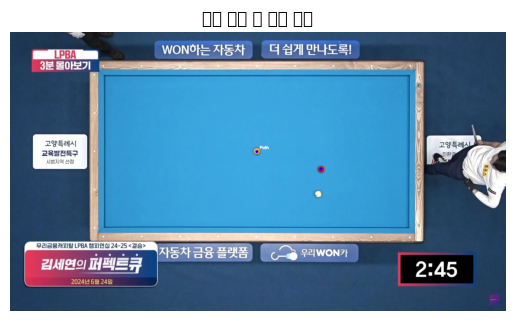

In [ ]:
# 메인 함수
def main():
    # 이미지 경로 및 .txt 파일 경로 설정
    image_path = "/content/drive/MyDrive/Aiffelthon/ModelTest/Data/Three-Ball_Billiards/success04_mp4-0008_jpg.rf.d60e12eb85771318f182477e8bb5c81a.jpg"
    txt_path = "/content/drive/MyDrive/Aiffelthon/ModelTest/Data/Three-Ball_Billiards/success04_mp4-0008_jpg.rf.d60e12eb85771318f182477e8bb5c81a.txt"

    # YOLO 탐지
    balls = detect_balls_with_yolo(image_path)
    if len(balls) < 3:
        print("YOLO 탐지 실패, .txt 파일을 불러옵니다.")
        balls_from_txt = load_coordinates_from_txt(txt_path)
        if len(balls_from_txt) < 3:
            print("공 좌표가 부족합니다.")
            return

        # .txt 좌표를 이미지 좌표로 변환
        image = cv2.imread(image_path)
        height, width, _ = image.shape
        balls = [yolo_to_image_coords(ball, width, height) for ball in balls_from_txt]

    cue_ball, target_ball_1, target_ball_2 = balls[0], balls[1], balls[2]
    table_dimensions = [0, 0, 1, 1]  # 당구대 경계

    # 시뮬레이션 및 시각화 호출
    simulate_shot_with_cushion_check(cue_ball, target_ball_1, target_ball_2, table_dimensions)

    image = cv2.imread(image_path)
    show_hit_point_with_trajectory(image, cue_ball, target_ball_1, target_ball_2)

# 프로그램 실행
main()